In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(label={self.label} data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1)  / (math.exp(2 * self.data) + 1), _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        visited = set()
        order = []
        def topology_sort(root):
            if root not in visited:
                visited.add(root)
                for child in root.prev:
                    topology_sort(child)
                order.append(root)

        topology_sort(self)
        self.grad = 1.0
        for node in order[::-1]:
            node._backward()   
        

In [115]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        dot.node(uid, label="{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape='record')
        if node._op:
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)
    for child, node in edges:
        dot.edge(str(id(child)), str(id(node)) + node._op)
        

    return dot

In [127]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b
d = e + c
d.label = 'd'
e.label = 'e'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'


In [126]:
# manual backpropriation - chain rule
L.grad = 1.0
# dL/dd = dL * f
d.grad = L.grad * f.data
# dL/df = dL * d
f.grad = L.grad * d.data
# dL/dc = dL/dd * dd/dc = dL/dd * 1
c.grad = d.grad * 1.0
# dL/de = dL/dd * dd/de = dL/dd * 1
e.grad = d.grad * 1.0 
# dL/da = dL/dd * dd/de * de/da = dl/de * b
a.grad = e.grad * b.data
# dL/db = dL/dd * dd/de * de/db = dL/de * a
b.grad = e.grad * a.data

In [128]:
# auto backpropagation
L.backward()

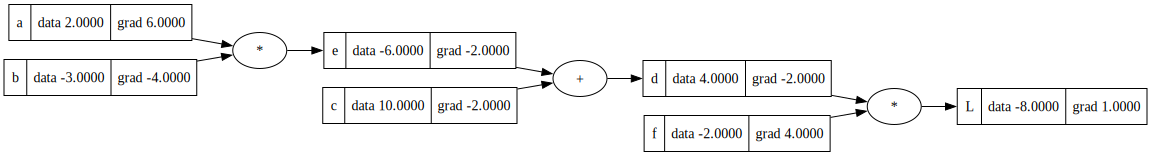

In [129]:
draw_dot(L)